In [1]:
import os
import sys
import time
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from sklearn.model_selection import train_test_split

from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial

# To ignore UserWarnings
import warnings
warnings.filterwarnings('ignore')

# Import local function
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'src'))

from metrics import get_metrics_df
from narmax.utils import narmax_state_space

$$\Large\text{Linear 2D ODE}$$
$$\large \dot{x} = -0.1x + 2y$$
$$\large \dot{y} = -2x - 0.1y$$

$$\large \dot{x} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} x \qquad x \in \R^2$$

$$\large\begin{split}\frac{d}{dt} \begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x \\ y\end{bmatrix}\end{split}$$

In [2]:
def f(x, t):
    return [-0.1 * x[0] + 2 * x[1],
            -2 * x[0] - 0.1 * x[1]]
sol_terms = [['x', 'y'], ['x', 'y']]

t = np.arange(0, 25, 0.01)
x = odeint(f, [2, 0], t)

# Split Gnerated Data into Train-Test
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.75, shuffle=False)

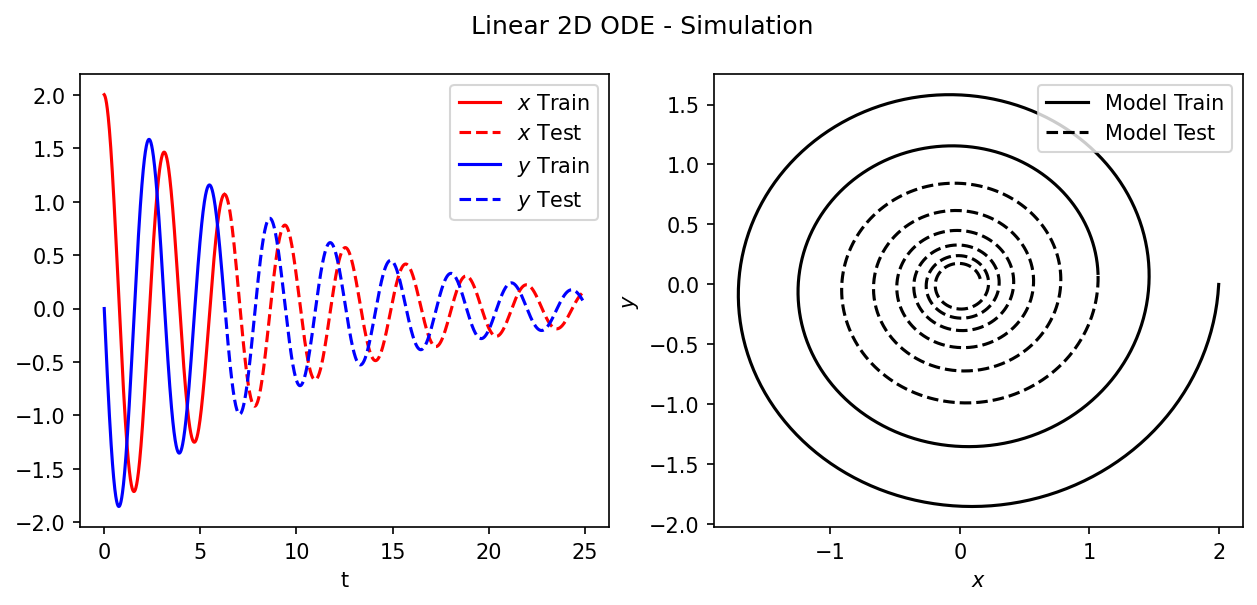

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 2D ODE - Simulation')
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

In [4]:
# Define SINDy Model
sindy_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.05),
    feature_library=ps.PolynomialLibrary(degree=5),
    feature_names=['x', 'y']
)
# Fit model and get time taken
tic = time.time()
sindy_model.fit(x_train, t=t_train, quiet=True)
toc = time.time()
sindy_time = toc - tic

# Print resulting model
sindy_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_model.simulate(x_test[0], t_test)

x' = -0.100 x + 2.000 y
y' = -2.000 x + -0.100 y


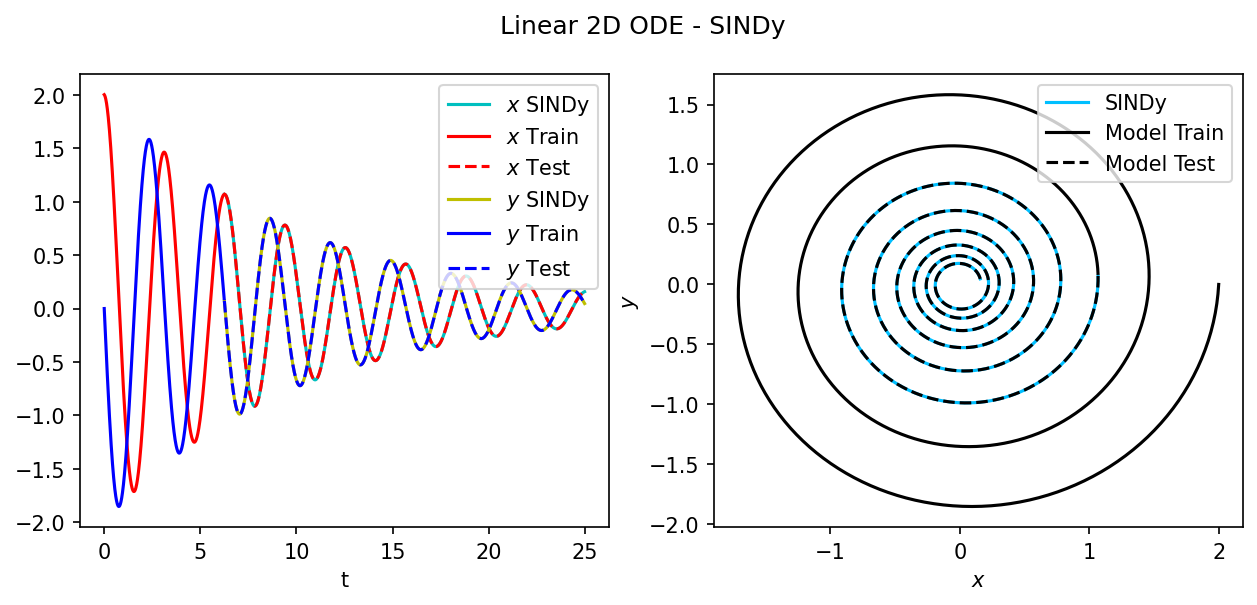

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 2D ODE - SINDy')
axs[0].plot(t_test, sindy_sim[:, 0], "c", label="$x$ SINDy")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, sindy_sim[:, 1], "y", label="$y$ SINDy")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(sindy_sim[:, 0], sindy_sim[:, 1], "deepskyblue", label="SINDy")
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

In [6]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=1, xlag=1,
    estimator='recursive_least_squares',
    basis_function=Polynomial(degree=5)
)

narmax_model, narmax_sim, narmax_time = narmax_state_space(nx_model, x_train, x_test, ['x', 'y'])

x[k+1] = 9.984E-01 x[k] + 1.996E-02 y[k]
y[k+1] = 9.984E-01 y[k] - 1.996E-02 x[k]


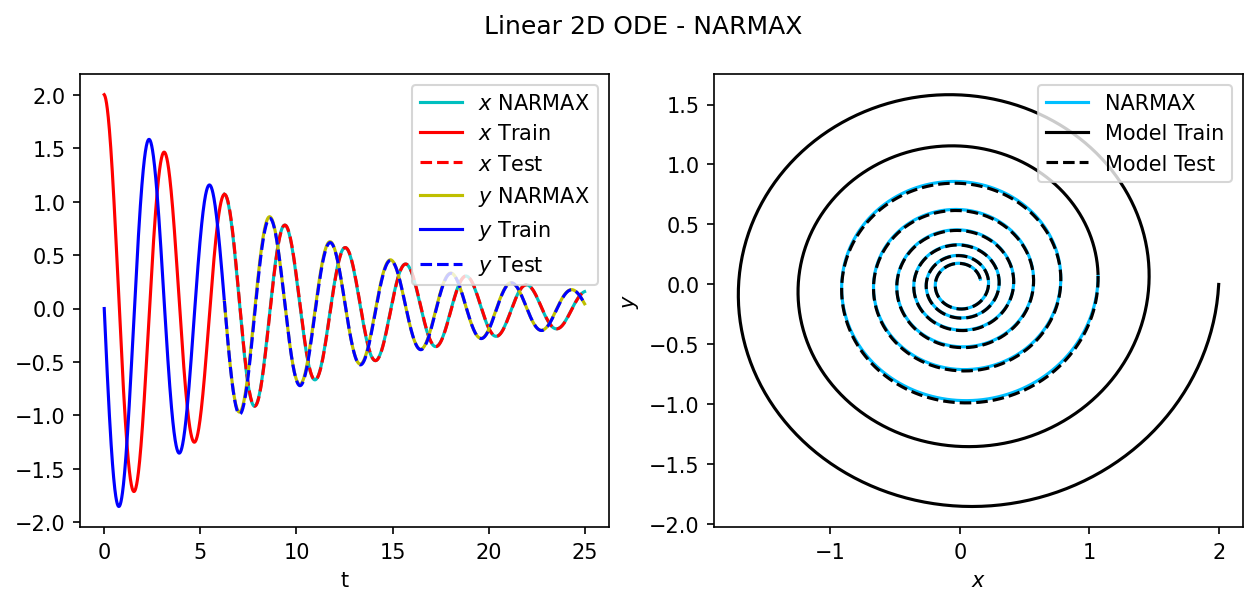

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 2D ODE - NARMAX')
axs[0].plot(t_test, narmax_sim[:, 0], "c", label="$x$ NARMAX")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, narmax_sim[:, 1], "y", label="$y$ NARMAX")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(narmax_sim[:, 0], narmax_sim[:, 1], "deepskyblue", label="NARMAX")
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

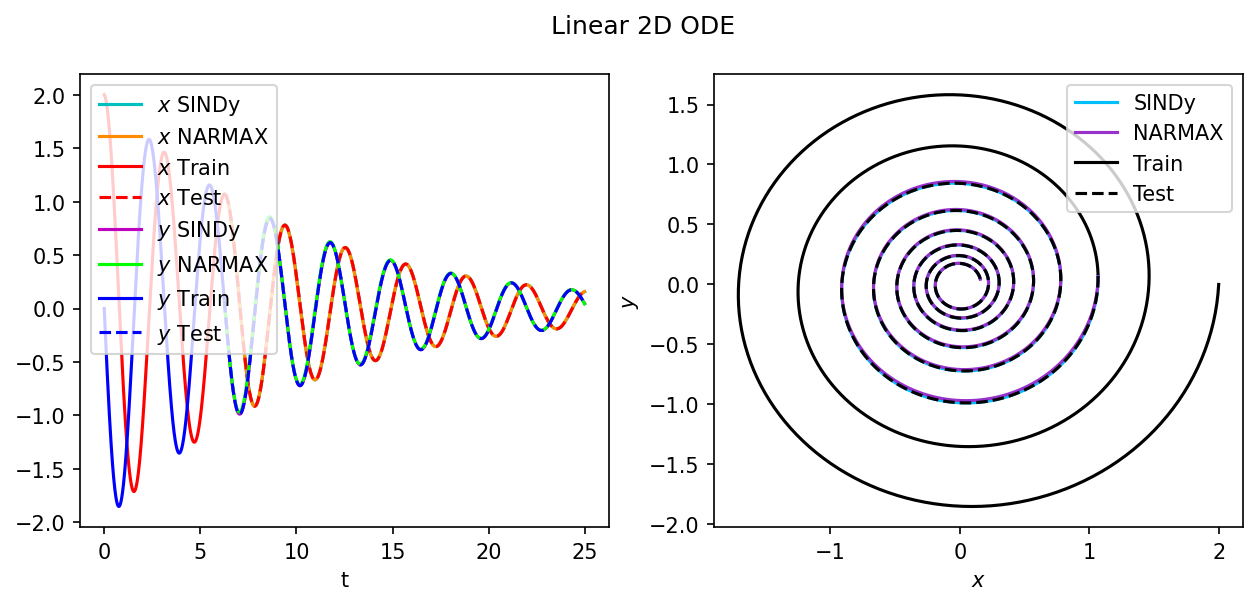

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 2D ODE')
axs[0].plot(t_test, sindy_sim[:, 0], 'c', label='$x$ SINDy')
axs[0].plot(t_test, narmax_sim[:, 0], 'darkorange', label='$x$ NARMAX')
axs[0].plot(t_train, x_train[:, 0], 'r', label='$x$ Train')
axs[0].plot(t_test, x_test[:, 0], 'r--', label='$x$ Test')

axs[0].plot(t_test, sindy_sim[:, 1], 'm', label='$y$ SINDy')
axs[0].plot(t_test, narmax_sim[:, 1], 'lime', label='$y$ NARMAX')
axs[0].plot(t_train, x_train[:, 1], 'b', label='$y$ Train')
axs[0].plot(t_test, x_test[:, 1], 'b--', label='$y$ Test')

axs[0].set(xlabel='t')
axs[0].legend()
axs[1].plot(sindy_sim[:, 0], sindy_sim[:, 1], 'deepskyblue', label='SINDy')
axs[1].plot(narmax_sim[:, 0], narmax_sim[:, 1], 'darkorchid', label='NARMAX')
axs[1].plot(x_train[:, 0], x_train[:, 1], 'k', label='Train')
axs[1].plot(x_test[:, 0], x_test[:, 1], 'k--', label='Test')
axs[1].set(xlabel='$x$', ylabel='$y$')
axs[1].legend()
print(end='')

In [9]:
# Metrics DataFrame
get_metrics_df(x_test, sol_terms, sindy_model, narmax_model, sindy_sim, narmax_sim, sindy_time, narmax_time)

,CII,COI,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,Time
SINDy,"[True, True]",True,"[2, 2]","[0, 0]",4,0.000007,9.824762e-08,0.000812,0.011334
NARMAX,"[True, True]",True,"[2, 2]","[0, 0]",4,-0.003124,9.639280e-05,0.025488,0.528287


$$\Large\text{Cubic 2D ODE}$$
$$\large \dot{x} = -0.1x^3 + 2y^3$$
$$\large \dot{y} = -2x^3 - 0.1y^3$$

$$\large \dot{x} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} x^3 \qquad x \in \R^2$$

$$\large\begin{split}\frac{d}{dt}\begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix}-0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x^3 \\ y^3\end{bmatrix}\end{split}$$

In [10]:
def f(x, t):
    return [-0.1 * x[0]**3 + 2 * x[1]**3,
            -2 * x[0]**3 - 0.1 * x[1]**3]
sol_terms = [['x^3', 'y^3'], ['x^3', 'y^3']]

t = np.arange(0, 25, 0.001)
x = odeint(f, [2, 0], t)

# Split Gnerated Data into Train-Test
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.75, shuffle=False)

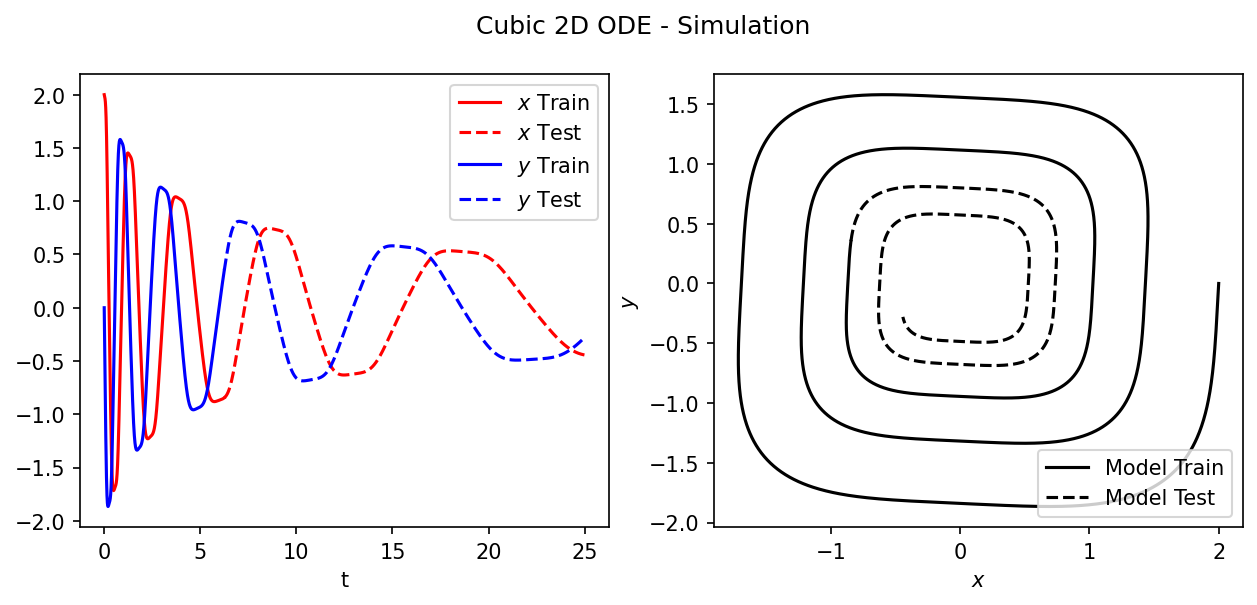

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Cubic 2D ODE - Simulation')
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

In [12]:
# Define SINDy Model
sindy_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.05),
    feature_library=ps.PolynomialLibrary(degree=5),
    feature_names=['x', 'y']
)
# Fit model and get time taken
tic = time.time()
sindy_model.fit(x_train, t=t_train, quiet=True)
toc = time.time()
sindy_time = toc - tic

# Print resulting model
sindy_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_model.simulate(x_test[0], t_test)

x' = -0.100 x^3 + 2.000 y^3
y' = -2.000 x^3 + -0.100 y^3


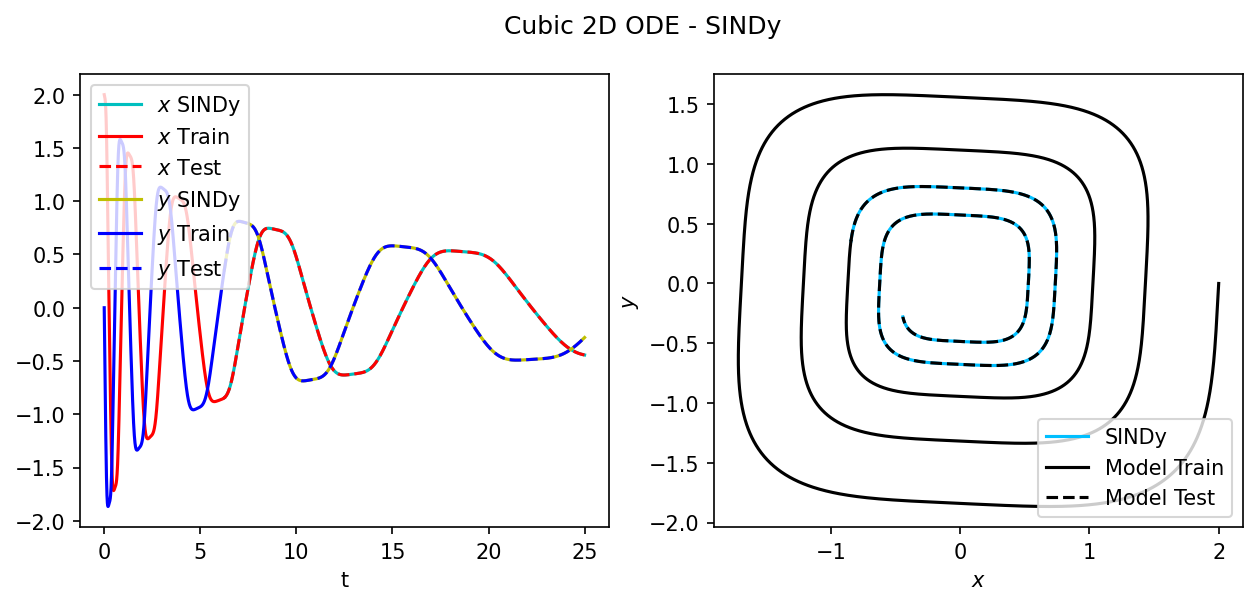

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Cubic 2D ODE - SINDy')
axs[0].plot(t_test, sindy_sim[:, 0], "c", label="$x$ SINDy")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, sindy_sim[:, 1], "y", label="$y$ SINDy")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(sindy_sim[:, 0], sindy_sim[:, 1], "deepskyblue", label="SINDy")
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

In [14]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=1, xlag=1,
    estimator='recursive_least_squares',
    basis_function=Polynomial(degree=5)
)

narmax_model, narmax_sim, narmax_time = narmax_state_space(nx_model, x_train, x_test, ['x', 'y'])

x[k+1] = 1.000E+00 x[k] + 2.000E-03 y[k]^3 - 1.000E-04 x[k]^3 - 1.799E-05 y[k]^2x[k]^3 - 9.377E-07 y[k]^5 - 3.657E-07 y[k]^3x[k]^2 + 4.398E-08 y[k]x[k]^4
y[k+1] = 1.000E+00 y[k] - 2.000E-03 x[k]^3 - 9.998E-05 y[k]^3 - 1.802E-05 x[k]^2y[k]^3 + 9.090E-07 x[k]^5 + 2.800E-07 x[k]^3y[k]^2


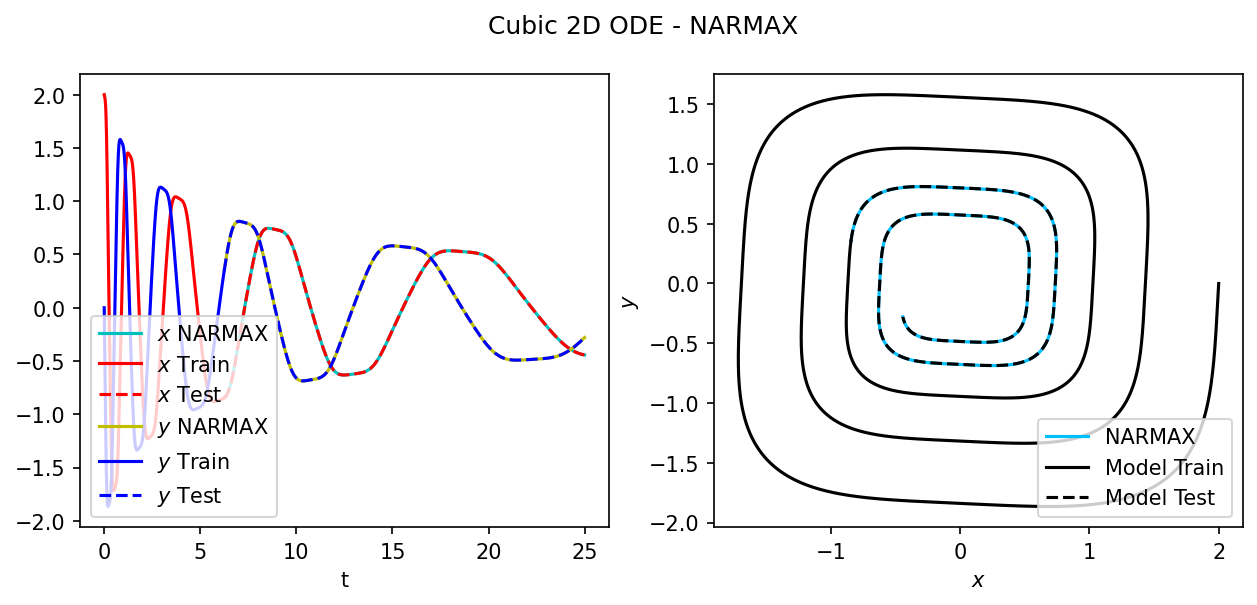

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Cubic 2D ODE - NARMAX')
axs[0].plot(t_test, narmax_sim[:, 0], "c", label="$x$ NARMAX")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, narmax_sim[:, 1], "y", label="$y$ NARMAX")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(narmax_sim[:, 0], narmax_sim[:, 1], "deepskyblue", label="NARMAX")
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

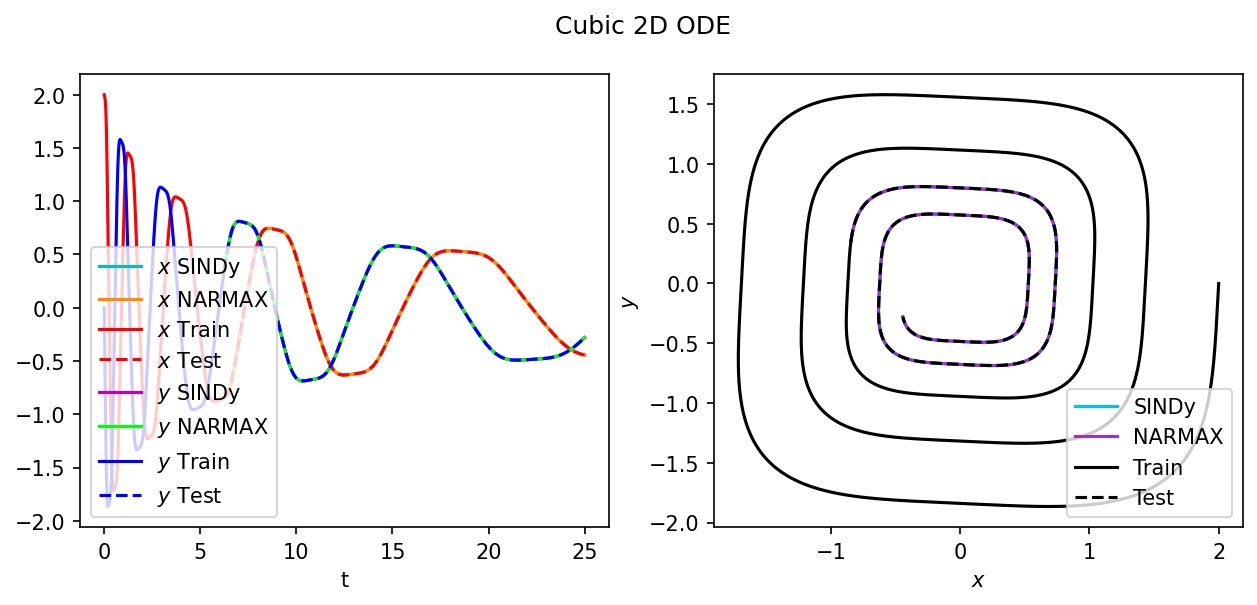

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Cubic 2D ODE')
axs[0].plot(t_test, sindy_sim[:, 0], 'c', label='$x$ SINDy')
axs[0].plot(t_test, narmax_sim[:, 0], 'darkorange', label='$x$ NARMAX')
axs[0].plot(t_train, x_train[:, 0], 'r', label='$x$ Train')
axs[0].plot(t_test, x_test[:, 0], 'r--', label='$x$ Test')

axs[0].plot(t_test, sindy_sim[:, 1], 'm', label='$y$ SINDy')
axs[0].plot(t_test, narmax_sim[:, 1], 'lime', label='$y$ NARMAX')
axs[0].plot(t_train, x_train[:, 1], 'b', label='$y$ Train')
axs[0].plot(t_test, x_test[:, 1], 'b--', label='$y$ Test')

axs[0].set(xlabel='t')
axs[0].legend()
axs[1].plot(sindy_sim[:, 0], sindy_sim[:, 1], 'deepskyblue', label='SINDy')
axs[1].plot(narmax_sim[:, 0], narmax_sim[:, 1], 'darkorchid', label='NARMAX')
axs[1].plot(x_train[:, 0], x_train[:, 1], 'k', label='Train')
axs[1].plot(x_test[:, 0], x_test[:, 1], 'k--', label='Test')
axs[1].set(xlabel='$x$', ylabel='$y$')
axs[1].legend()
print(end='')

In [17]:
# Metrics DataFrame
get_metrics_df(x_test, sol_terms, sindy_model, narmax_model, sindy_sim, narmax_sim, sindy_time, narmax_time)

,CII,COI,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,Time
SINDy,"[True, True]",True,"[2, 2]","[0, 0]",4,-0.000002,7.990085e-11,0.000019,0.018020
NARMAX,"[True, True]",True,"[7, 6]","[5, 4]",13,0.000328,3.337810e-07,0.001231,5.377771


$$\Large\text{Linear 3D ODE}$$
$$\large \dot{x} = -0.1x + 2y$$
$$\large \dot{y} = -2x - 0.1y$$
$$\large \dot{z} = -0.3z$$

$$\large \dot{x} = \begin{bmatrix} -0.1 & 2 & 0\\ -2 & -0.1 & 0\\ 0 & 0 & -0.3\end{bmatrix} x \qquad x \in \R^2$$

$$\large\begin{split}\frac{d}{dt}\begin{bmatrix}x \\ y \\ z \end{bmatrix} = \begin{bmatrix}-0.1 & -2 & 0 \\ 2 & -0.1 & 0 \\ 0 & 0 & -0.3 \end{bmatrix} \begin{bmatrix}x \\ y \\ z \end{bmatrix}\end{split}$$

In [18]:
def f(x, t):
    return [-0.1 * x[0] + 2 * x[1],
            -2 * x[0] - 0.1 * x[1],
            -0.3 * x[2]]
sol_terms = [['x', 'y'], ['x', 'y'], ['z']]

t = np.arange(0, 50, 0.01)
x = odeint(f, [2, 0, 1], t)

# Split Gnerated Data into Train-Test
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.6, shuffle=False)

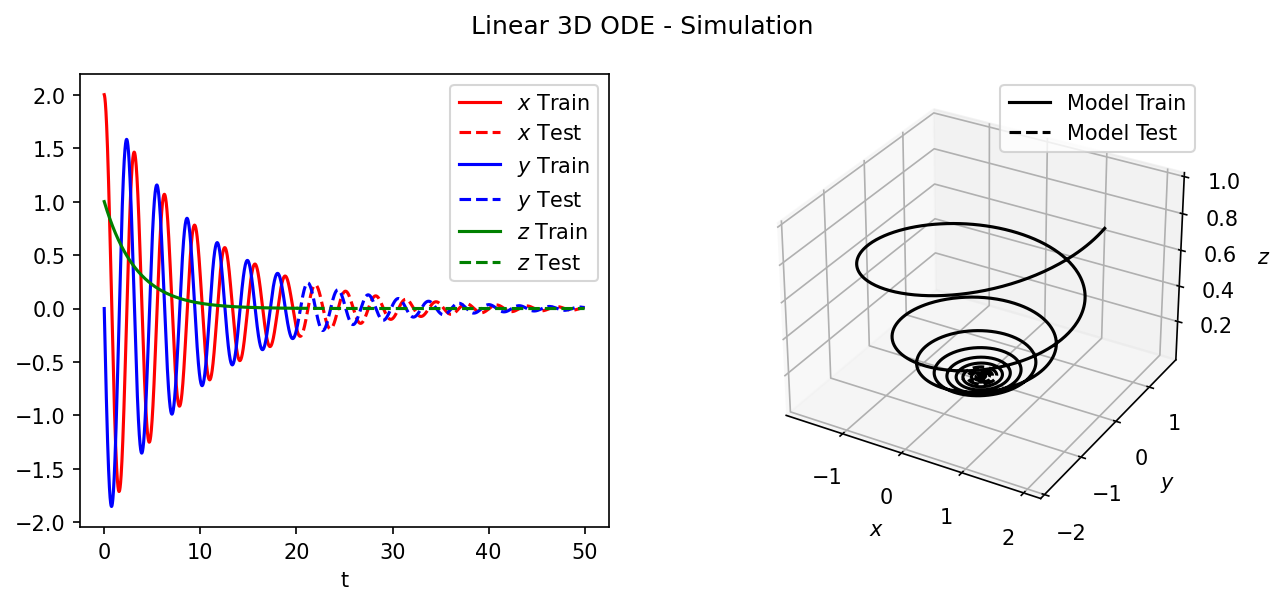

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 3D ODE - Simulation')
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [20]:
# Define SINDy Model
sindy_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.01),
    feature_library=ps.PolynomialLibrary(degree=5),
    feature_names=['x', 'y', 'z']
)
# Fit model and get time taken
tic = time.time()
sindy_model.fit(x_train, t=t_train, quiet=True)
toc = time.time()
sindy_time = toc - tic

# Print resulting model
sindy_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_model.simulate(x_test[0], t_test)

x' = -0.100 x + 2.000 y
y' = -2.000 x + -0.100 y
z' = -0.300 z


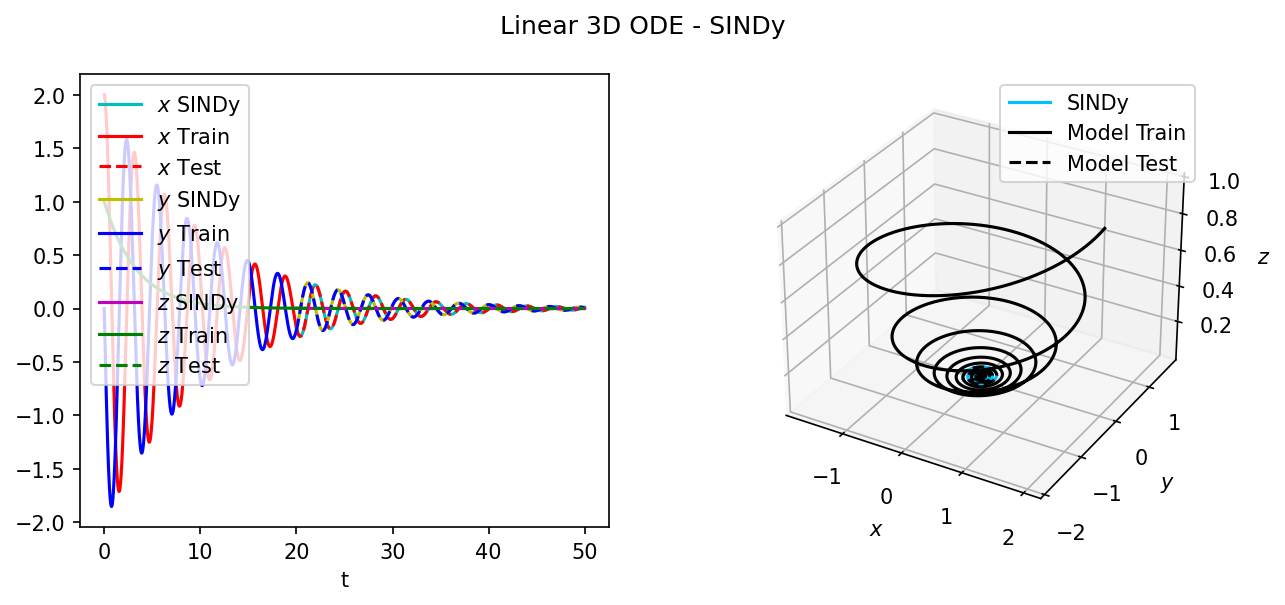

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 3D ODE - SINDy')
axs[0].plot(t_test, sindy_sim[:, 0], "c", label="$x$ SINDy")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, sindy_sim[:, 1], "y", label="$y$ SINDy")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_test, sindy_sim[:, 2], "m", label="$z$ SINDy")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(sindy_sim[:, 0], sindy_sim[:, 1], sindy_sim[:, 2], "deepskyblue", label="SINDy")
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [22]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=1, xlag=[[1],[1]],
    estimator='recursive_least_squares',
    basis_function=Polynomial(degree=5)
)

narmax_model, narmax_sim, narmax_time = narmax_state_space(nx_model, x_train, x_test, ['x', 'y', 'z'])

x[k+1] = 9.984E-01 x[k] + 1.996E-02 y[k]
y[k+1] = 9.984E-01 y[k] - 1.996E-02 x[k]
z[k+1] = 9.970E-01 z[k]


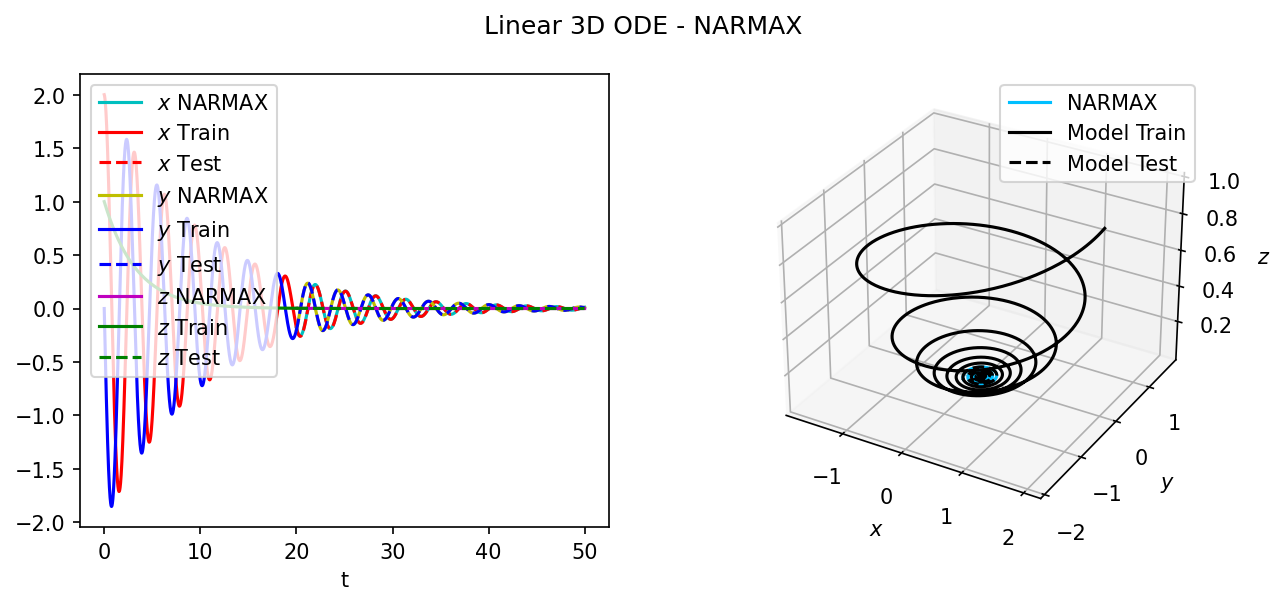

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 3D ODE - NARMAX')
axs[0].plot(t_test, narmax_sim[:, 0], "c", label="$x$ NARMAX")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, narmax_sim[:, 1], "y", label="$y$ NARMAX")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_test, narmax_sim[:, 2], "m", label="$z$ NARMAX")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(narmax_sim[:, 0], narmax_sim[:, 1], narmax_sim[:, 2], "deepskyblue", label="NARMAX")
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

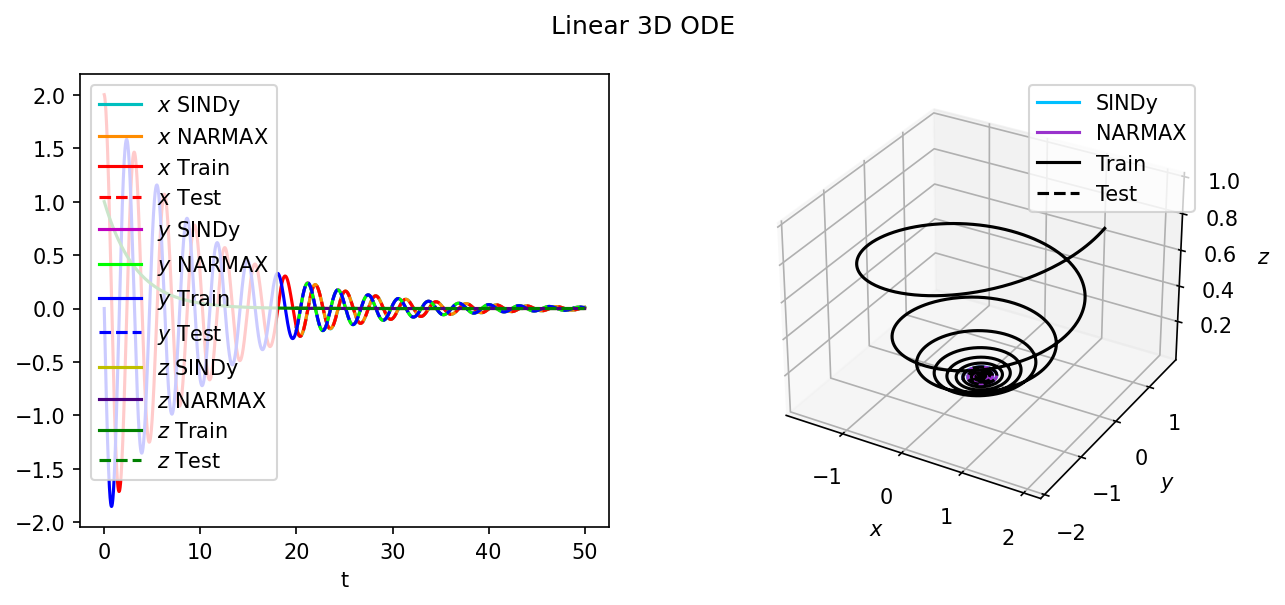

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 3D ODE')
axs[0].plot(t_test, sindy_sim[:, 0], 'c', label='$x$ SINDy')
axs[0].plot(t_test, narmax_sim[:, 0], 'darkorange', label='$x$ NARMAX')
axs[0].plot(t_train, x_train[:, 0], 'r', label='$x$ Train')
axs[0].plot(t_test, x_test[:, 0], 'r--', label='$x$ Test')

axs[0].plot(t_test, sindy_sim[:, 1], 'm', label='$y$ SINDy')
axs[0].plot(t_test, narmax_sim[:, 1], 'lime', label='$y$ NARMAX')
axs[0].plot(t_train, x_train[:, 1], 'b', label='$y$ Train')
axs[0].plot(t_test, x_test[:, 1], 'b--', label='$y$ Test')

axs[0].plot(t_test, sindy_sim[:, 2], "y", label="$z$ SINDy")
axs[0].plot(t_test, narmax_sim[:, 2], "indigo", label="$z$ NARMAX")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")

axs[0].set(xlabel='t')
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(sindy_sim[:, 0], sindy_sim[:, 1], sindy_sim[:, 2], "deepskyblue", label="SINDy")
axs[1].plot(narmax_sim[:, 0], narmax_sim[:, 1], narmax_sim[:, 2], "darkorchid", label="NARMAX")
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [25]:
# Metrics DataFrame
get_metrics_df(x_test, sol_terms, sindy_model, narmax_model, sindy_sim, narmax_sim, sindy_time, narmax_time)

,CII,COI,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,Time
SINDy,"[True, True, True]",True,"[2, 2, 1]","[0, 0, 0]",5,3.978070e-07,3.407523e-09,0.000916,0.069614
NARMAX,"[True, True, True]",True,"[2, 2, 1]","[0, 0, 0]",5,-4.206055e-05,2.603567e-06,0.025394,3.105774


$$\Large\text{Lorenz System}$$
$$\large \begin{split} \dot{x} & = \sigma(y-x)\\\dot{y} & = x(\rho - z) - y\\\dot{z} & = xy-\beta z\end{split}\\\large\sigma = 10 \qquad \rho = 28 \qquad \beta = \frac{8}{3}$$

In [26]:
# Lorenz System
sigma = 10
rho = 28
beta = 8/3

def lorenz(x, t):
    return [sigma * (x[1] - x[0]),
            x[0] * (rho - x[2]) - x[1],
            x[0] * x[1] - beta * x[2]]
sol_terms = [['x', 'y'], ['x', 'x z', 'y'], ['x y', 'z']]


t = np.arange(0, 25, 0.0005)
x = odeint(lorenz, [-8, 8, 27], t)

# Split Gnerated Data into Train-Test
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.75, shuffle=False)

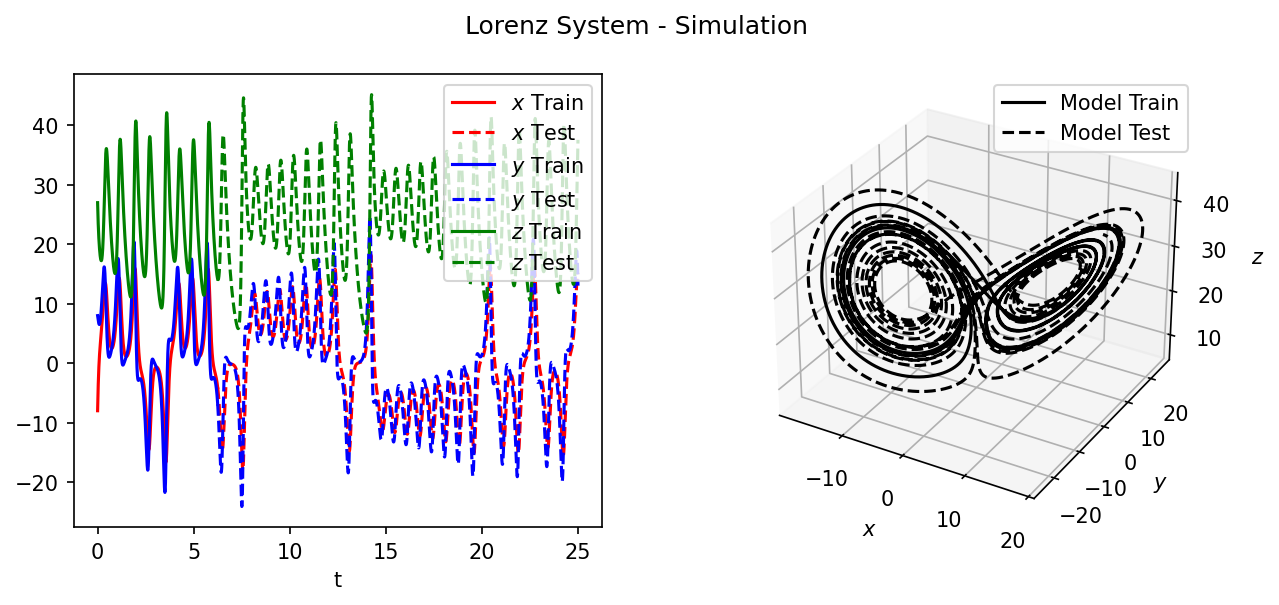

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Lorenz System - Simulation')
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [28]:
# Define SINDy Model
sindy_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.01),
    feature_library=ps.PolynomialLibrary(degree=5),
    feature_names=['x', 'y', 'z']
)
# Fit model and get time taken
tic = time.time()
sindy_model.fit(x_train, t=t_train, quiet=True)
toc = time.time()
sindy_time = toc - tic

# Print resulting model
sindy_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_model.simulate(x_test[0], t_test)

x' = -10.000 x + 10.000 y
y' = 28.000 x + -1.000 y + -1.000 x z
z' = -2.667 z + 1.000 x y


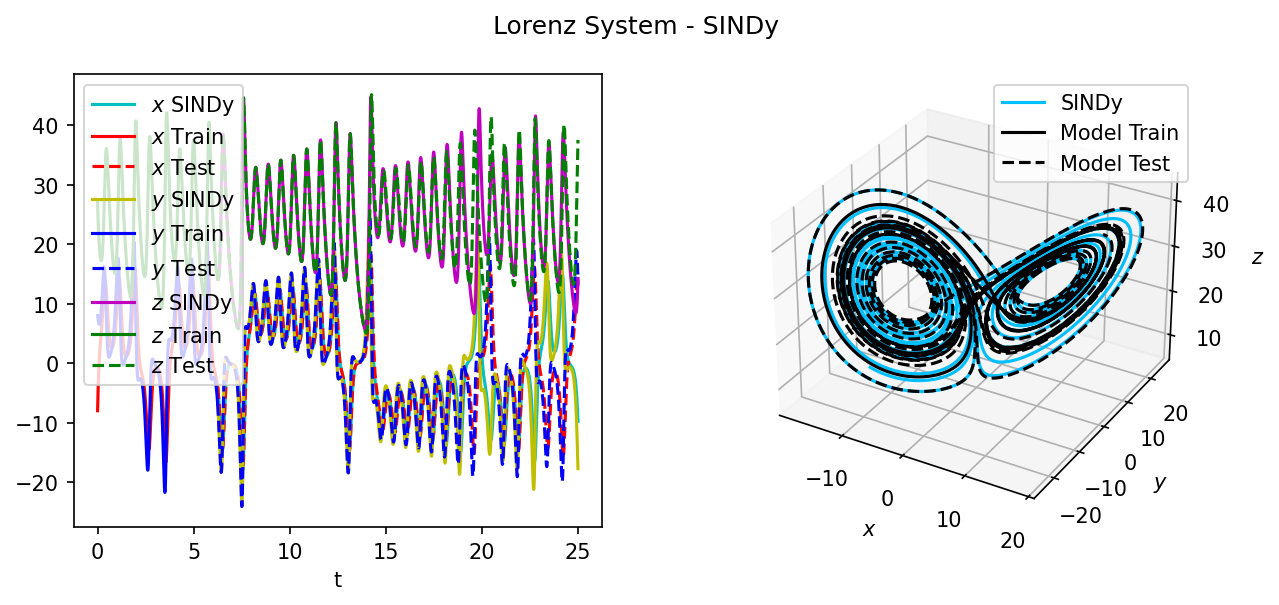

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Lorenz System - SINDy')
axs[0].plot(t_test, sindy_sim[:, 0], "c", label="$x$ SINDy")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, sindy_sim[:, 1], "y", label="$y$ SINDy")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_test, sindy_sim[:, 2], "m", label="$z$ SINDy")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(sindy_sim[:, 0], sindy_sim[:, 1], sindy_sim[:, 2], "deepskyblue", label="SINDy")
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [30]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=1, xlag=[[1],[1]],
    estimator='recursive_least_squares',
    basis_function=Polynomial(degree=5)
)

narmax_model, narmax_sim, narmax_time = narmax_state_space(nx_model, x_train, x_test, ['x', 'y', 'z'])

x[k+1] = 9.951E-01 x[k] + 4.984E-03 y[k] - 3.741E-06 z[k]x[k] - 1.447E-09 y[k]x[k]^2 + 4.447E-09 z[k]y[k]
y[k+1] = 9.996E-01 y[k] + 1.128E-10 z[k]x[k]^3 + 6.877E-12 x[k]^5 - 3.728E-06 z[k]y[k] - 4.255E-13 z[k]^4x[k] + 1.389E-02 x[k] - 4.951E-04 z[k]x[k] - 3.784E-07 x[k]^2y[k]
z[k+1] = 9.987E-01 z[k] + 4.957E-04 y[k]x[k] - 4.496E-11 x[k]^2z[k]^2 + 3.739E-06 y[k]^2 - 2.641E-11 x[k]^4 - 5.285E-09 y[k]x[k]z[k] + 1.031E-05 x[k]^2 - 3.672E-07 x[k]^2z[k]


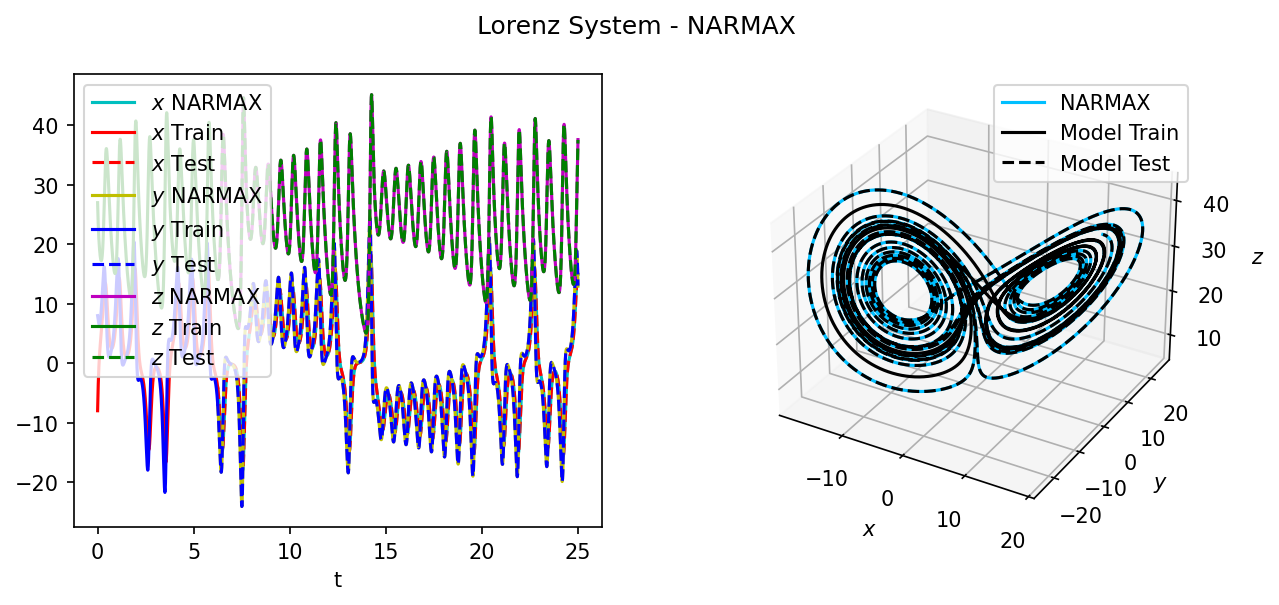

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Lorenz System - NARMAX')
axs[0].plot(t_test, narmax_sim[:, 0], "c", label="$x$ NARMAX")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, narmax_sim[:, 1], "y", label="$y$ NARMAX")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_test, narmax_sim[:, 2], "m", label="$z$ NARMAX")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(narmax_sim[:, 0], narmax_sim[:, 1], narmax_sim[:, 2], "deepskyblue", label="NARMAX")
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

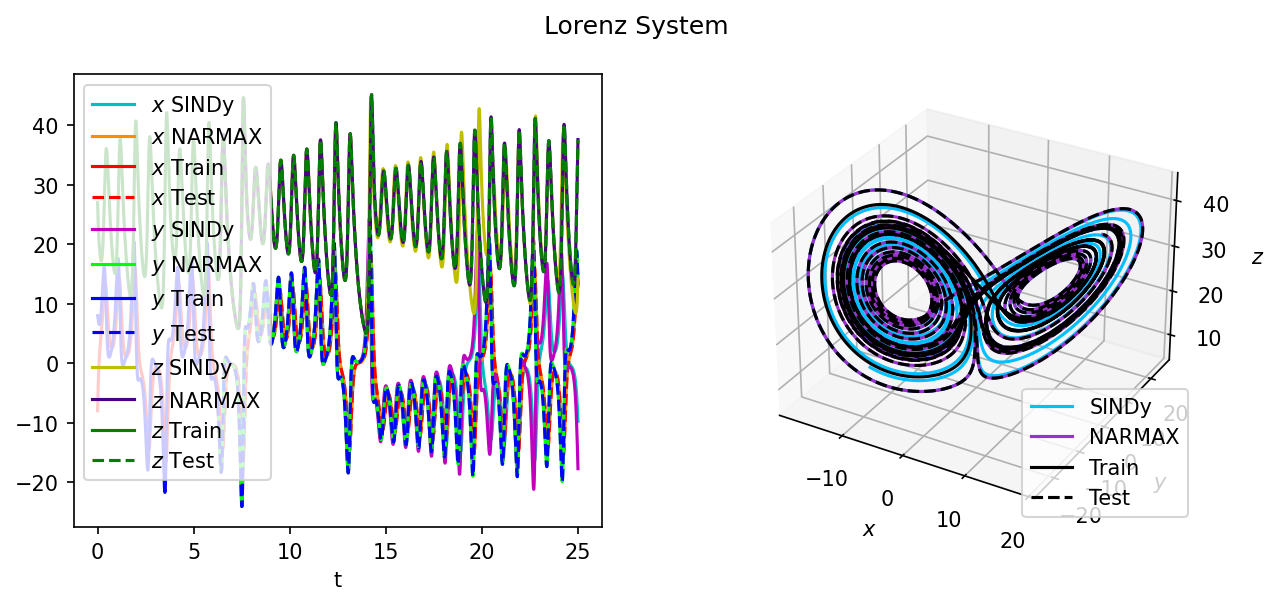

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Lorenz System')
axs[0].plot(t_test, sindy_sim[:, 0], 'c', label='$x$ SINDy')
axs[0].plot(t_test, narmax_sim[:, 0], 'darkorange', label='$x$ NARMAX')
axs[0].plot(t_train, x_train[:, 0], 'r', label='$x$ Train')
axs[0].plot(t_test, x_test[:, 0], 'r--', label='$x$ Test')

axs[0].plot(t_test, sindy_sim[:, 1], 'm', label='$y$ SINDy')
axs[0].plot(t_test, narmax_sim[:, 1], 'lime', label='$y$ NARMAX')
axs[0].plot(t_train, x_train[:, 1], 'b', label='$y$ Train')
axs[0].plot(t_test, x_test[:, 1], 'b--', label='$y$ Test')

axs[0].plot(t_test, sindy_sim[:, 2], "y", label="$z$ SINDy")
axs[0].plot(t_test, narmax_sim[:, 2], "indigo", label="$z$ NARMAX")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")

axs[0].set(xlabel='t')
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(sindy_sim[:, 0], sindy_sim[:, 1], sindy_sim[:, 2], "deepskyblue", label="SINDy")
axs[1].plot(narmax_sim[:, 0], narmax_sim[:, 1], narmax_sim[:, 2], "darkorchid", label="NARMAX")
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [33]:
# Metrics DataFrame
get_metrics_df(x_test, sol_terms, sindy_model, narmax_model, sindy_sim, narmax_sim, sindy_time, narmax_time)

,CII,COI,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,Time
SINDy,"[True, True, True]",True,"[2, 3, 2]","[0, 0, 0]",7,-0.116566,47.042059,0.814473,0.067841
NARMAX,"[True, True, True]",True,"[5, 8, 8]","[3, 5, 6]",21,-0.001157,0.000955,0.003660,15.695461
